# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

### Example 2: Larger newsvendor problem
We now consider a larger Newsvendor problem, with two sets of products. 
The robust problem is 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & \tau + y\\
		\text{subject to} & k_1^Tx_1 - p_1^T\min\{x_1, u\} \le \tau \quad \forall u \in \mathcal{U}(\theta) \\
		& k_2^Tx_2 - p_2^T\min\{x_2, u\} \le y \quad \forall u \in \mathcal{U}(\theta) \\
		& x_1 \geq x_2 \geq 0.
	\end{array}
\end{equation*}

In [2]:
# Formulate constants
n = 15
N = 300
np.random.seed(399)
k = npr.uniform(2,5,n)
p = k + npr.uniform(0.5,2,n)
k1 = npr.uniform(1,3,n)
p1 = k1 + npr.uniform(0,2,n)
k_tch = torch.tensor(k, requires_grad = True)
# p_tch = torch.tensor(p, requires_grad = True)
k1_tch = torch.tensor(k1, requires_grad = True)
p1_tch = torch.tensor(p1, requires_grad = True)

def loss(t,y,x, x1, p_tch, alpha, data, mu = 100, l=1000, quantile = 0.95, target = 0.):
    sums =  torch.mean(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t-alpha, 
        torch.tensor(0.,requires_grad = True)))+ torch.mean(torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y-alpha, 
        torch.tensor(0.,requires_grad = True)))
    sums = sums/(2*(1-quantile)) + alpha
    return t +y + l*(sums - target) + (mu/2)*(sums - target)**2, t+y, 0.5*torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()) + 0.5*torch.mean((torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y, 
        torch.tensor(0.,requires_grad = True))>=0.001).float()), sums.detach().numpy()


def loss(t,y,x, x1, p_tch, alpha, data, mu = 100, l=1000, quantile = 0.95, target = 0.):
    Nsample = data.shape[0]
    sums =  torch.mean(torch.maximum(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t-alpha, 
        torch.tensor(0.,requires_grad = True)), 
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y-alpha))
    sums = sums/(1-quantile) + alpha
    return t +y + l*(sums - target) + (mu/2)*(sums - target)**2, t+y, torch.sum((torch.maximum(torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t-alpha, 
        torch.tensor(0.,requires_grad = True)), 
        torch.maximum(k1_tch@x1 -data@p1_tch, k1_tch@x1 - p1_tch@x) - y-alpha))>= torch.tensor(1.))/Nsample, sums.detach().numpy()


def gen_demand(n, N, seed=399):
    np.random.seed(seed)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,2,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return mu, sig, d_train

# Generate data
mu, sig, data = gen_demand(n,N*2)

scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene+1)
    scenarios[scene] = {}
    scenarios[scene][0] = p + np.random.normal(0,1,n)

In [5]:
np.random.seed(16)
data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x_r = cp.Variable(n)
x_1 = cp.Variable(n)
t = cp.Variable()
y = cp.Variable()
p = cp.Parameter(n)
# p1 = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t+y)


# constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
# constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]
constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]

constraints += [x_r >= 0, x_r >= x_1]

prob = lropt.RobustProblem(objective, constraints)
target = -0.015
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.000001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 10)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.concatenate((np.linspace(0.6, 0.9, 60), np.linspace(0.93, 2.5, 15))), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.concatenate((np.linspace(0.01, 0.6, 60), np.linspace(0.61, 2.5, 15))), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

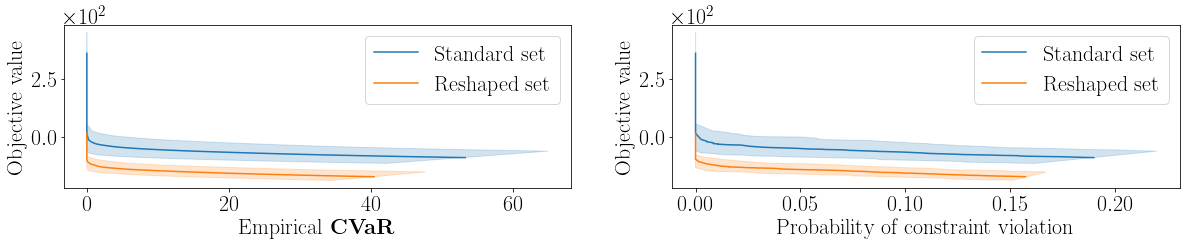

In [45]:
plot_tradeoff(dfgrid,dfgrid2,"News",ind_1=(0,100),ind_2=(0,100) )

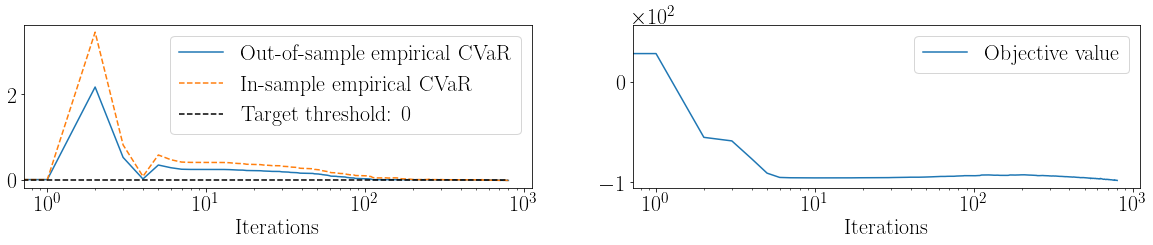

In [20]:
plot_iters(df1,"News", steps = 800,logscale = 1)

In [46]:
def eval(t,y,x, x1, p1, p,data):
    t = torch.tensor(t)
    y = torch.tensor(y)
    x = torch.tensor(x)
    x1 = torch.tensor(x1)
    p_tch = torch.tensor(p)
    p1 = torch.tensor(p1)
    data = torch.tensor(data)
    return 0.5*torch.mean((torch.maximum(
        torch.maximum(k_tch@x -data@p_tch, k_tch@x - p_tch@x) - t, 
        torch.tensor(0.,requires_grad = True))>=0.0001).float()) + 0.5*torch.mean((torch.maximum(
        torch.maximum(k1_tch@x1 -data@p1, k1_tch@x1 - p1@x) - y, 
        torch.tensor(0.,requires_grad = True))>=0.0001).float())

def eval(t,y,x, x1, p1, p,data):
    t = torch.tensor(t)
    y = torch.tensor(y)
    x = torch.tensor(x)
    x1 = torch.tensor(x1)
    p = torch.tensor(p)
    p1 = torch.tensor(p1)
    data = torch.tensor(data)
    Nsample = data.shape[0]
    return torch.sum((torch.maximum(torch.maximum(
        torch.maximum(k_tch@x -data@p, k_tch@x - p@x) - t, 
        torch.tensor(0.,requires_grad = True)), 
        torch.maximum(k1_tch@x1 -data@p1, k1_tch@x1 - p1@x) - y))>= torch.tensor(1.))/Nsample

def make_table(result_A,result_b, dfgrid,test, value,eps, cvar_train, cvar_test):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(n,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))
        # Formulate the Robust Problem
        x_r = cp.Variable(n)
        x_1 = cp.Variable(n)
        t = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter(n)
        # p1 = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t+y)

        constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]
        # constraints = [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
        # constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]

        constraints += [x_r >= 0, x_r >= x_1]

        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        trial1[scene,0] = newprob.objective.value
        trial1[scene,1] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,test).item()
        trial1[scene,2] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,train).item()
        trial1[scene,3] = cvar_train
        trial1[scene,4] = cvar_test
        trial1[scene,5] = newprob.solver_stats.solve_time
    return trial1
def mro(train, test, K = 300, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(n,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
            # Formulate the Robust Problem
        x_r = cp.Variable(n)
        x_1 = cp.Variable(n)
        t = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter(n)
        # p1 = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t+y)

        constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]

        constraints += [x_r >= 0, x_r >= x_1]

        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = newprob.objective.value
        vios[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,test).item()
        vios_1[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios_1, objs, time


def sg(train, test):
    vios = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
            # Formulate the Robust Problem
        x_r = cp.Variable(n)
        x_1 = cp.Variable(n)
        t = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter(n)
        # p1 = cp.Parameter(n)
        p.value = scenarios[scene][0]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t+y)
        constraints = [x_r >= 0, x_r >= x_1]
        for u in train:
          constraints += [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]
          # constraints += [cp.maximum(k@x_r - p@x_r, k@x_r - p@u) <= t]
          # constraints += [cp.maximum(k1@x_1 - p1@x_1, k1@x_1 - p1@u) <= y]
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        objs[scene] = prob.objective.value
        vios[scene] = eval(t.value,y.value,x_r.value, x_1.value,p1,p.value,test).item()
        time[scene] = prob.solver_stats.solve_time
    return vios, objs, time

In [53]:
Ar_saved = np.zeros((100,15,15))
br_saved = np.zeros((100,15))
As_saved = np.zeros((100,15,15))
bs_saved = np.zeros((100,15))
reshaped_table = np.zeros((1,18))
standard_table = np.zeros((1,18))
for experiment in range(100):
    np.random.seed(experiment)
    data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
    # Formulate uncertainty set
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    x_1 = cp.Variable(n)
    t = cp.Variable()
    y = cp.Variable()
    p = cp.Parameter(n)
    # p1 = cp.Parameter(n)
    p.value = scenarios[0][0]
    # p1.value = scenarios[0][1]
    objective = cp.Minimize(t+y)

    constraints = [cp.maximum(k@x_r - p@x_r - t, k@x_r - p@u - t,k1@x_1 - p1@x_1 - y,  k1@x_1 - p1@u - y) <= 0]

    constraints += [x_r >= 0, x_r >= x_1]

    prob = lropt.RobustProblem(objective, constraints)
    target = -0.015
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    result1 = prob.train(lr = 0.000001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 1, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 10)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    result3 = prob.train(eps = True, lr = 0.00001, step=800, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 1, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    df_r2 = result3.df
    As_saved[experiment,:] = result3.A
    bs_saved[experiment,:] = result3.b

    # Grid search epsilon
    result4 = prob.grid(epslst = np.concatenate((np.linspace(0.6, 0.9, 60), np.linspace(0.93, 2.5, 15))), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.concatenate((np.linspace(0.01, 0.6, 60), np.linspace(0.61, 2.5, 15))), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,0.03, eps = 0, cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,0., eps = 1,cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,0.04, eps = 1,cvar_train = df1["Violation_train"].values[-1], cvar_test = df1["Violation_val"].values[-1])
    r_t = np.hstack((r_t, r_t1, r_t2))
    
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(result3.A,result3.b, dfgrid,test, 0.03, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t1 = make_table(result3.A,result3.b, dfgrid,test, 0., eps = 1,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t2 = make_table(result3.A,result3.b, dfgrid,test, 0.04, eps = 0,cvar_train = df_r2["Violation_train"].values[-1], cvar_test = df_r2["Violation_val"].values[-1])
    s_t = np.hstack((s_t, s_t1, s_t2))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table_2.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table_2.csv")
    np.save("Ar_saved.npy", Ar_saved)
    np.save("As_saved.npy", As_saved)
    np.save("br_saved.npy", br_saved)
    np.save("bs_saved.npy", bs_saved)
# standard_table = pd.read_csv("standard_table_1.csv").iloc[:,1:]
# reshaped_table = pd.read_csv("reshaped_table_1.csv").iloc[:,1:]
# standard_table = standard_table.values
# reshaped_table = reshaped_table.values
# pd.DataFrame(standard_table).to_csv("standard_table_1.csv")
# pd.DataFrame(reshaped_table).to_csv("reshaped_table_1.csv")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

In [55]:
print("test_vio_target: ", np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1)),"\n""train_vio_target: ", np.mean(np.mean(reshaped_table[:,2].reshape(-1, 5), axis=1)),"\n""test_obj_target: ", np.mean(np.mean(reshaped_table[:,0].reshape(-1, 5), axis=1)),"\n""test_vio: ", np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1)),"\n""train_vio: ", np.mean(np.mean(reshaped_table[:,8].reshape(-1, 5), axis=1)),"\n""test_obj: ", np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1)),"\n""test_cvar: ", np.mean(np.mean(reshaped_table[:,4].reshape(-1, 5), axis=1)),"\n""train_cvar: ",np.mean(np.mean(reshaped_table[:,3].reshape(-1, 5), axis=1)))

test_vio_target:  0.030533333468250875 
train_vio_target:  0.02995333351660515 
test_obj_target:  -130.11514124883664 
test_vio:  0.0003133333371952146 
train_vio:  0.0 
test_obj:  -96.27419802587139 
test_cvar:  -0.0016150850905060936 
train_cvar:  -0.019516959125728716


In [56]:
print("test_vio_target: ", np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1)),"\n""train_vio_target: ", np.mean(np.mean(standard_table[:,2].reshape(-1, 5), axis=1)),"\n""test_obj_target: ", np.mean(np.mean(standard_table[:,0].reshape(-1, 5), axis=1)),"\n""test_vio: ", np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1)),"\n""train_vio: ", np.mean(np.mean(standard_table[:,8].reshape(-1, 5), axis=1)),"\n""test_obj: ", np.mean(np.mean(standard_table[:,6].reshape(-1, 5), axis=1)),"\n""test_cvar: ", np.mean(np.mean(standard_table[:,4].reshape(-1, 5), axis=1)),"\n""train_cvar: ",np.mean(np.mean(standard_table[:,3].reshape(-1, 5), axis=1)))

test_vio_target:  0.030453333570621865 
train_vio_target:  0.030006666737608573 
test_obj_target:  -44.111422808726445 
test_vio:  0.0007266666758805464 
train_vio:  0.00034000000823288646 
test_obj:  -5.671988895053987 
test_cvar:  -0.053975080003352084 
train_cvar:  -0.07688430724272212


In [57]:
print("DRO = ", np.mean(totalvios, axis = 0)[5] , np.mean(totalobjs,axis = 0)[5], np.mean(totaltime, axis = 0)[5])
print("SG = ", np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]),np.mean(sg_vals[:,2]))
print(np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) >= 0.05))
print(np.mean(sg_vals[:,0] >= 0.05))
print(np.mean(np.mean(totalvios[:,3].reshape(-1, 5), axis=1) > 0.05))

DRO =  0.00012000000197440385 -63.511619555785515 0.15704018218000024
SG =  0.001846666693687439 -150.85604686039022 0.016142951410000002
0.06
0.09
0.0
0.15


In [348]:
totalvios = np.zeros((num_scenarios*100,10))
totalvios_train =  np.zeros((num_scenarios*100,10))
totalobjs = np.zeros((num_scenarios*100,10))
totaltime = np.zeros((num_scenarios*100,10))
epsrange = np.linspace(0.1, 5, 10)
for experiment in range(100):
    print(experiment)
    np.random.seed(experiment)
    data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 300, rho = eps)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios2.npy", totalvios)
        np.save("totalvios_train2.npy", totalvios_train)
        np.save("totalobjs2.npy", totalobjs)
        np.save("totaltime2.npy", totaltime)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


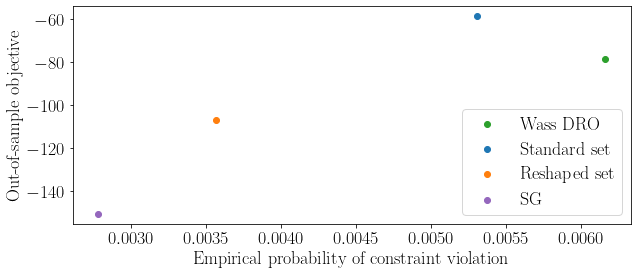

In [34]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totalvios, axis = 0)[6] , np.mean(totalobjs,axis = 0)[6], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,4]), np.mean(standard_table[:,3]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,4]), np.mean(reshaped_table[:,3]),label = "Reshaped set", color = "tab:orange")
plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

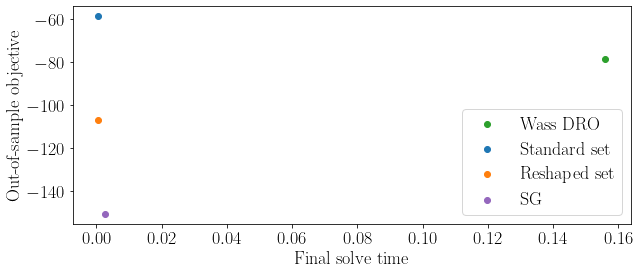

In [30]:
plt.figure(figsize = (10,4))
plt.scatter(np.mean(totaltime, axis = 0)[6] , np.mean(totalobjs,axis = 0)[6], color = "tab:green", label = " Wass DRO")
plt.scatter(np.mean(standard_table[:,5]), np.mean(standard_table[:,3]),label = "Standard set", color = "tab:blue")
plt.scatter(np.mean(reshaped_table[:,5]), np.mean(reshaped_table[:,3]),label = "Reshaped set", color = "tab:orange")
plt.scatter(np.mean(sg_vals[:,0]), np.mean(sg_vals[:,1]), label = "SG", color = "tab:purple")
plt.xlabel("Final solve time")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [44]:
print("reshaped = ", np.mean(reshaped_table[:,4])*2, np.mean(reshaped_table[:,3]),np.mean(reshaped_table[:,5]))
print("standard = ", np.mean(standard_table[:,4])*2, np.mean(standard_table[:,3]),np.mean(standard_table[:,5]))
print("DRO = ", np.mean(totalvios, axis = 0)[6]*2 , np.mean(totalobjs,axis = 0)[6], np.mean(totaltime, axis = 0)[6])
print("SG = ", np.mean(sg_vals[:,0])*2, np.mean(sg_vals[:,1]),np.mean(sg_vals[:,2]))

reshaped =  0.007133671819577449 -107.06029972551575 0.0005262797705583757
standard =  0.010619289428941121 -58.56273194455417 0.0005685917939086294
DRO =  0.012326666741631924 -78.59854222394392 0.15599188118
SG =  0.005566666716709733 -150.8560468577561 0.012848807482


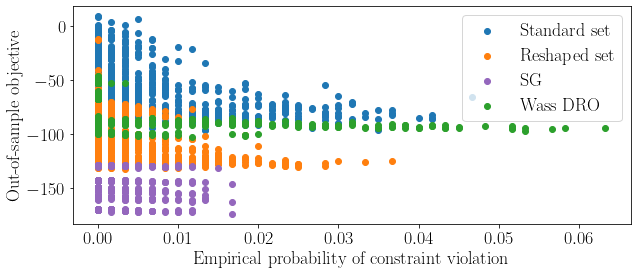

In [36]:
plt.figure(figsize = (10,4))
plt.scatter(standard_table[:,4], standard_table[:,3],label = "Standard set", color = "tab:blue")
plt.scatter(reshaped_table[:,4], reshaped_table[:,3],label = "Reshaped set", color = "tab:orange")
plt.scatter(sg_vals[:,0], sg_vals[:,1],label = "SG", color = "tab:purple")
plt.scatter(totalvios[:,6] ,totalobjs[:,6], color = "tab:green", label = " Wass DRO")
plt.xlabel("Empirical probability of constraint violation")
plt.ylabel("Out-of-sample objective")
plt.legend()
plt.show()

In [375]:
sg_vals = np.zeros((num_scenarios*100,3))
for experiment in range(100):
    print(experiment)
    np.random.seed(experiment)
    data = np.exp(np.random.multivariate_normal(mu,sig, N*2))
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=5)
    vios, objs, time = sg(train,test)
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),0] = vios 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),1] = objs 
    sg_vals[(experiment*num_scenarios):((experiment+1)*num_scenarios),2] = time
    np.save("sg_vals1.npy", sg_vals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [58]:
standard_table = pd.read_csv("standard_table_2.csv").iloc[:,1:].values
reshaped_table = pd.read_csv("reshaped_table_2.csv").iloc[:,1:].values
totalvios = np.load("totalvios2.npy")
totalvios_train = np.load("totalvios_train2.npy")
totalobjs = np.load("totalobjs2.npy")
totaltime = np.load("totaltime2.npy")
sg_vals = np.load("sg_vals1.npy")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

In [60]:
table = np.zeros((4,6))
table[0,0] =  np.mean(np.mean(reshaped_table[:,6].reshape(-1, 5), axis=1))
table[1,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1))
table[2,0] =  np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,0] =  np.mean(np.mean(reshaped_table[:,11].reshape(-1, 5), axis=1))

table[0,1] =  np.mean(np.mean(reshaped_table[:,0].reshape(-1, 5), axis=1))
table[1,1] =  np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1))
table[2,1] =  np.mean(np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) >= 0.05)
table[3,1] =  np.mean(np.mean(reshaped_table[:,5].reshape(-1, 5), axis=1))

table[0,2] =  np.mean(np.mean(standard_table[:,6].reshape(-1, 5), axis=1))
table[1,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1))
table[2,2] =  np.mean(np.mean(standard_table[:,7].reshape(-1, 5), axis=1) >= 0.05)
table[3,2] =  np.mean(np.mean(standard_table[:,11].reshape(-1, 5), axis=1))

table[0,3] =  np.mean(np.mean(standard_table[:,0].reshape(-1, 5), axis=1))
table[1,3] =  np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1))
table[2,3] =  np.mean(np.mean(standard_table[:,1].reshape(-1, 5), axis=1) >= 0.05)
table[3,3] =  np.mean(np.mean(standard_table[:,5].reshape(-1, 5), axis=1))

table[0,4] =  np.mean(totalobjs,axis = 0)[3]
table[1,4] =  np.mean(totalvios, axis = 0)[3]
table[2,4] =  np.mean(np.mean(totalvios[:,3].reshape(-1, 5), axis=1) >= 0.05)
table[3,4] =  np.mean(totaltime, axis = 0)[3]

table[0,5] =  np.mean(sg_vals[:,1])
table[1,5] =  np.mean(sg_vals[:,0])
table[2,5] =  np.mean(sg_vals[:,0] >= 0.05)
table[3,5] =  np.mean(sg_vals[:,2])
pd.DataFrame(table).to_csv("table_vals3.csv")
